## Sfincs results: animation

The example used in this notebook is based on a regular SFINCS model, i.e. no subgrid tables are used. In the absence of the subgrid tables, SFINCS computes the water depth by simply substracting the bed levels from the water levels. The (maximum) water depth **h(max)** is stored in the NetCDF output (*sfincs_map.nc*). 

How to derive maximum water depths for a model including subgrid tables is explained [in a notebook about maximum water depths](sfincs_results_hmax.ipynb). A similar downscaling approach should be applied while making animations of a subgrid model!

In [1]:
# import dependencies
import xarray as xr
import numpy as np
from os.path import join
import matplotlib.pyplot as plt
import hydromt
from hydromt_sfincs import SfincsModel

We use the [cartopy](https://scitools.org.uk/cartopy/docs/latest/) package to plot maps. This packages provides a simple interface to plot geographic data and add background satellite imagery.

### Read model results

The model results in sfincs_map.nc are saved as in a staggered grid format, see [SGRID convention](https://publicwiki.deltares.nl/display/NETCDF/Deltares+proposal+for+Staggered+Grid+data+model+(SGRID)). Here we show how to retrieve the face values and translate the dimensions from node indices (m, n) to (x, y) coordinates in order to plot the results on a map.

In [2]:
sfincs_root = "indus_sfincs_model"  # (relative) path to sfincs root
mod = SfincsModel(sfincs_root, mode="r")

In [3]:
# we can simply read the model results (sfincs_map.nc and sfincs_his.nc) using the read_results method
mod.read_results()

### Plot instantaneous water depths

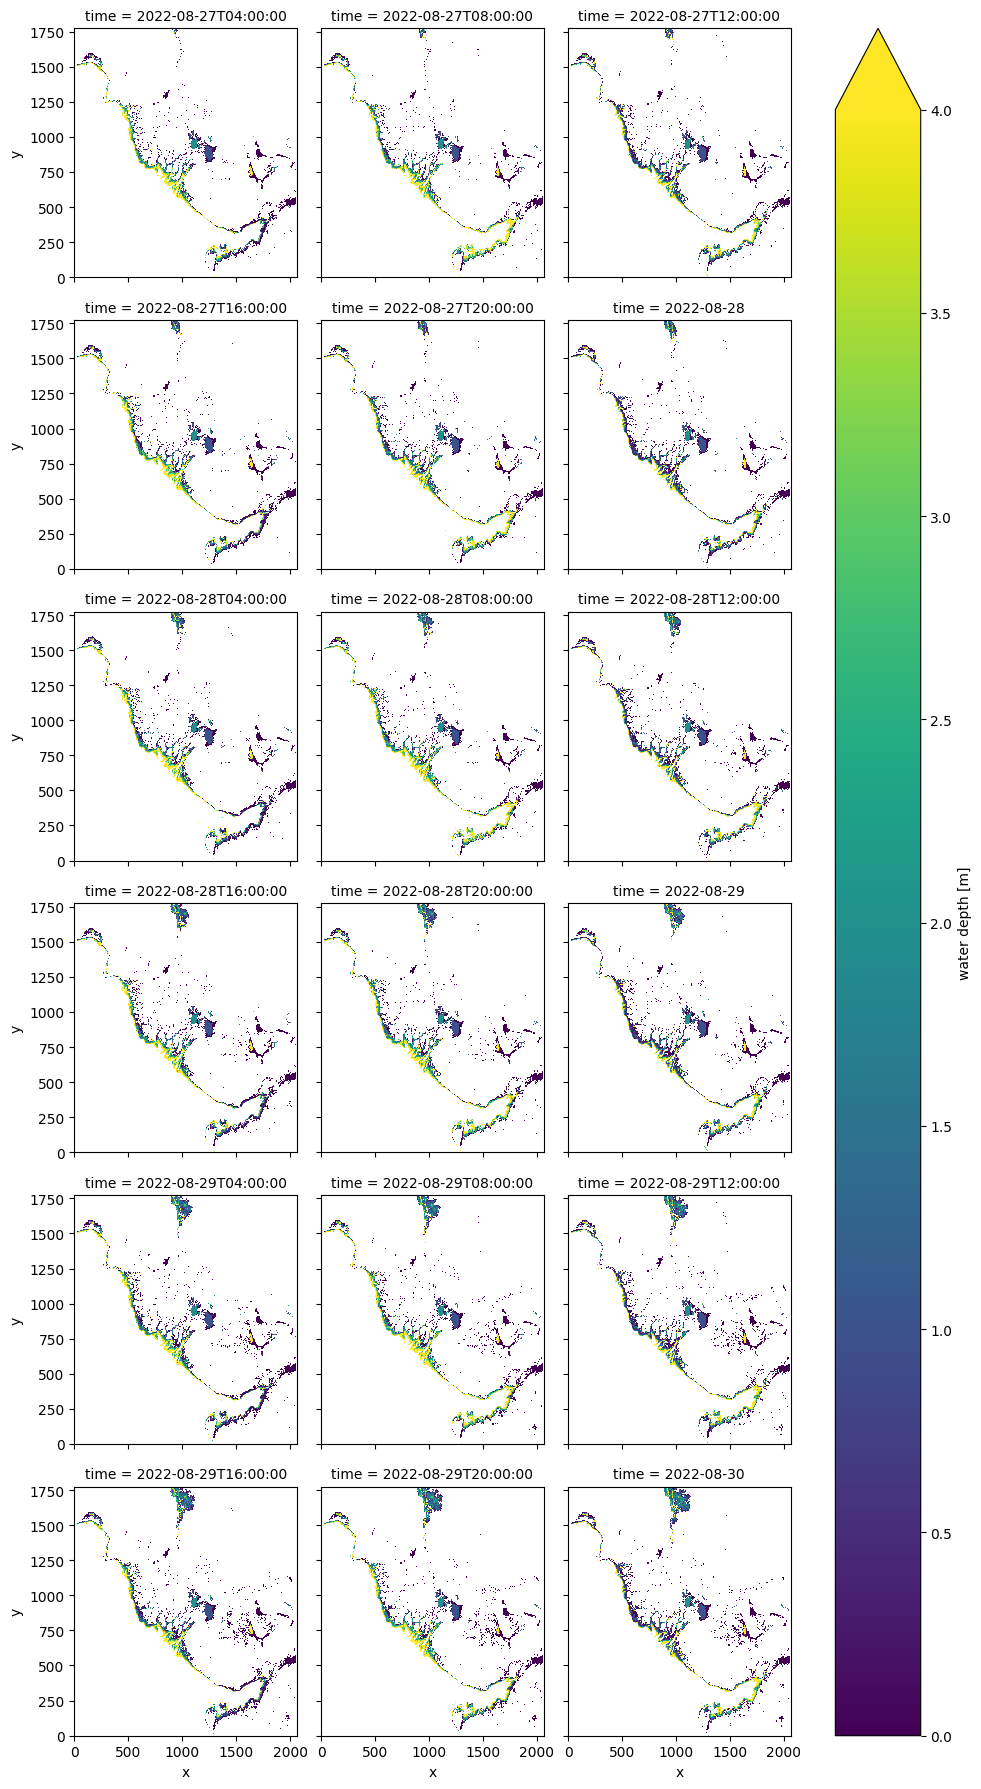

In [4]:
# h from sfincs_map contains the water depths for each cell face
# here we plot the water level every 4th hour
h = mod.results["h"].where(mod.results["h"] > 0)
h.attrs.update(long_name="water depth", unit="m")
h.sel(time=h["time"].values[4::4]).plot(col="time", col_wrap=3, vmax=4)

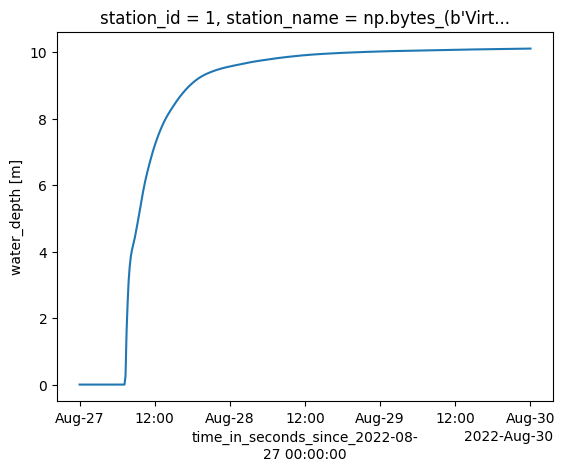

In [13]:
# point_h contains the water depths at the sfincs.obs gauge locations
# see mod.plot_basemaps (or next figure) for the location of the observation points
h_point = mod.results["point_h"].rename({"stations": "station_id"})
h_point["station_id"] = h_point["station_id"].astype(int)

# plot the water level at the first gauge
_ = h_point.sel({"station_id": 1}).plot.line(
    x="time",
)

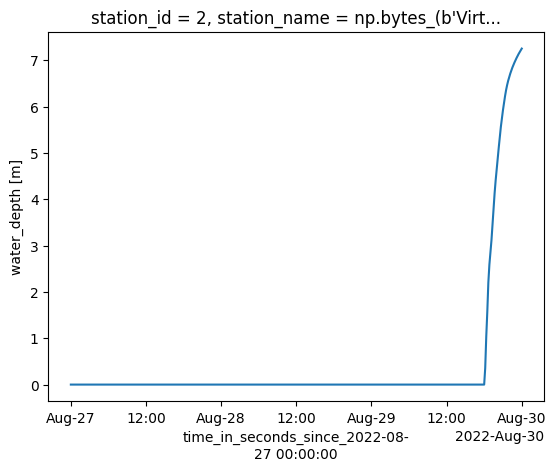

In [6]:
# point_h contains the water depths at the sfincs.obs gauge locations
# see mod.plot_basemaps (or next figure) for the location of the observation points
h_point = mod.results["point_h"].rename({"stations": "station_id"})
h_point["station_id"] = h_point["station_id"].astype(int)

# plot the water level at the first gauge
_ = h_point.sel({"station_id": 2}).plot.line(
    x="time",
)

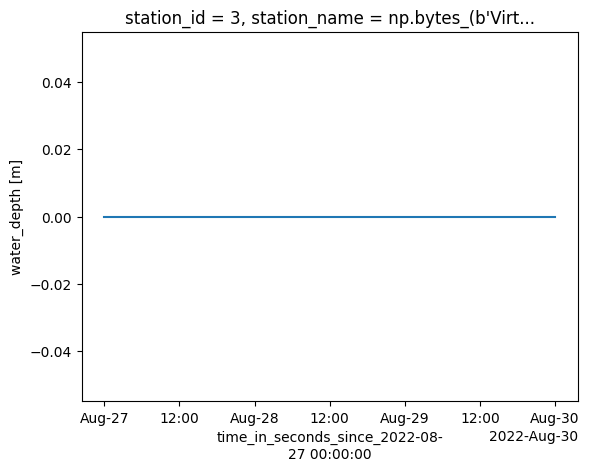

In [7]:
# point_h contains the water depths at the sfincs.obs gauge locations
# see mod.plot_basemaps (or next figure) for the location of the observation points
h_point = mod.results["point_h"].rename({"stations": "station_id"})
h_point["station_id"] = h_point["station_id"].astype(int)

# plot the water level at the first gauge
_ = h_point.sel({"station_id": 3}).plot.line(
    x="time",
)

### Create animation

An animation is also simple to make with `matplotlib.animation` method. Here we add the surface water level in blue colors next to the overland flood depth with viridis colormap. 

In [8]:
# mask water depth
hmin = 0.05
da_h = mod.results["h"].copy()
da_h = da_h.where(da_h > hmin).drop("spatial_ref")
da_h.attrs.update(long_name="flood depth", unit="m")

In [10]:
# create hmax plot and save to mod.root/figs/sfincs_h.mp4
# requires ffmpeg install with "conda install ffmpeg -c conda-forge"
from matplotlib import animation

step = 1  # one frame every <step> dtout
cbar_kwargs = {"shrink": 0.6, "anchor": (0, 0)}


def update_plot(i, da_h, cax_h):
    da_hi = da_h.isel(time=i)
    t = da_hi.time.dt.strftime("%d-%B-%Y %H:%M:%S").item()
    ax.set_title(f"SFINCS water depth {t}")
    cax_h.set_array(da_hi.values.ravel())


fig, ax = mod.plot_basemap(
    fn_out=None, variable="", bmap="sat", plot_bounds=False, figsize=(11, 7)
)
cax_h = da_h.isel(time=0).plot(
    x="xc", y="yc", ax=ax, vmin=0, vmax=3, cmap=plt.cm.viridis, cbar_kwargs=cbar_kwargs
)
plt.close()  # to prevent double plot

ani = animation.FuncAnimation(
    fig,
    update_plot,
    frames=np.arange(0, da_h.time.size, step),
    interval=250,  # ms between frames
    fargs=(
        da_h,
        cax_h,
    ),
)

# to save to mp4
ani.save(join(mod.root, 'figs', 'sfincs_h.mp4'), fps=4, dpi=200)

# to show in notebook:
from IPython.display import HTML

HTML(ani.to_html5_video())

In [11]:
ani.save(join(mod.root, 'figs', 'sfincs_h.mp4'), fps=4, dpi=200)